# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine((-6.0,6.0), translate=(0.1,0.1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F

# dropout_value = 0.1 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),  
            nn.BatchNorm2d(8),
            # nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        # self.convblock3 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # output_size = 10

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 5
        
        # CONVOLUTION BLOCK 3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # output_size = 3
        
        # OUTPUT BLOCK
        # self.gap = nn.Sequential(
        #     nn.AvgPool2d(kernel_size=6)
        # ) # output_size = 1

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )

        self.dropout_1 = nn.Dropout(0.1)
        self.dropout_2 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.dropout_1(x)
        x = self.convblock3(x)
        x = self.pool2(x)
        x = self.dropout_2(x)
        x = self.convblock4(x)
        # x = self.gap(x)        
        x = self.convblock5(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary -q
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [8]:
from torch.optim.lr_scheduler import StepLR, MultiStepLR

EPOCHS = 15

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)
scheduler = MultiStepLR(optimizer, [6, 13], gamma=0.1, verbose=True)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.1014036312699318 Batch_id=468 Accuracy=92.73: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]

Adjusting learning rate of group 0 to 1.0000e-01.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0717, Accuracy: 9775/10000 (97.75%)

EPOCH: 1


Loss=0.04732508584856987 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]

Adjusting learning rate of group 0 to 1.0000e-01.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9814/10000 (98.14%)

EPOCH: 2


Loss=0.02679339610040188 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]

Adjusting learning rate of group 0 to 1.0000e-01.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9855/10000 (98.55%)

EPOCH: 3


Loss=0.08457330614328384 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]

Adjusting learning rate of group 0 to 1.0000e-01.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.1333301067352295 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]

Adjusting learning rate of group 0 to 1.0000e-01.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.21889591217041016 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]

Adjusting learning rate of group 0 to 1.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.030076978728175163 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]

Adjusting learning rate of group 0 to 1.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.023618729785084724 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]

Adjusting learning rate of group 0 to 1.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.05062515661120415 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]

Adjusting learning rate of group 0 to 1.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.027060741558670998 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]

Adjusting learning rate of group 0 to 1.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.05360119044780731 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]


Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.026054853573441505 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]

Adjusting learning rate of group 0 to 1.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.06327056139707565 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]

Adjusting learning rate of group 0 to 1.0000e-03.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.05582599714398384 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]

Adjusting learning rate of group 0 to 1.0000e-03.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.034003984183073044 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]

Adjusting learning rate of group 0 to 1.0000e-03.



Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

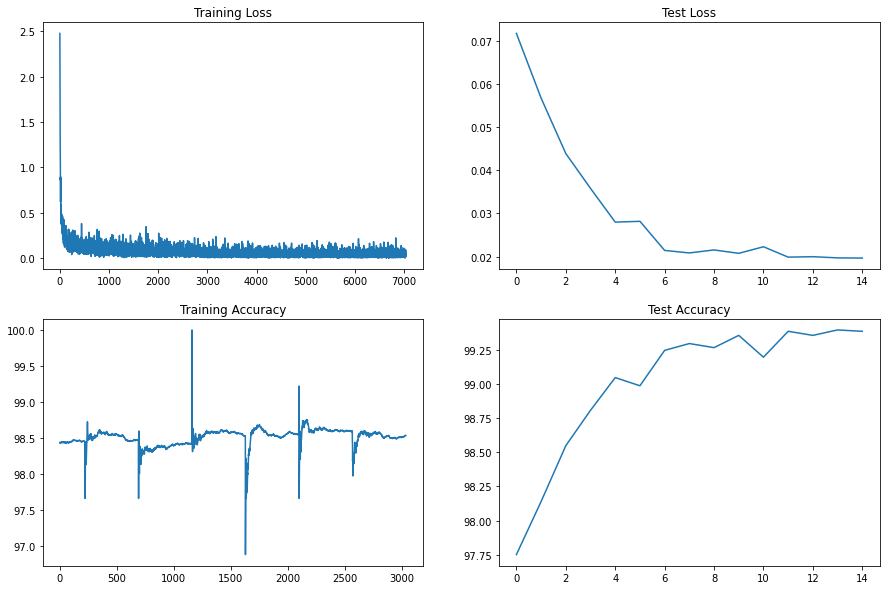

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")